<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/ERII_%E2%80%94_Ergontropic_Regime%E2%80%93Intermittency_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ .cdsapirc configurado
✅ Cliente CDS inicializado
✅ ERA5 já existe
✅ Dataset ERA5 carregado

=== IPI ANUAL ===

Outono 2004 → Inverno 2005: IPI = 68748.2
Outono 2005 → Inverno 2006: IPI = 56473.8
Outono 2006 → Inverno 2007: IPI = 142022.9
Outono 2007 → Inverno 2008: IPI = 94008.4
Outono 2008 → Inverno 2009: IPI = 47034.3
Outono 2009 → Inverno 2010: IPI = 67051.8
Outono 2010 → Inverno 2011: IPI = 54628.1
Outono 2011 → Inverno 2012: IPI = 85941.9
Outono 2012 → Inverno 2013: IPI = 83797.5
Outono 2013 → Inverno 2014: IPI = 51174.5
Outono 2014 → Inverno 2015: IPI = 46354.0
Outono 2015 → Inverno 2016: IPI = 73571.0
Outono 2016 → Inverno 2017: IPI = 218731.8
Outono 2017 → Inverno 2018: IPI = 81045.9
Outono 2018 → Inverno 2019: IPI = 100589.9
Outono 2019 → Inverno 2020: IPI = 102039.4
Outono 2020 → Inverno 2021: IPI = 137818.9
Outono 2021 → Inverno 2022: IPI = 62389.5
Outono 2022 → Inverno 2023: IPI = 70295.5

🔮 PREVISÃO ESTRUTURAL DO PRÓXIMO INVERNO
IPI normalizado = -0.40
Classificação: 🟩 I

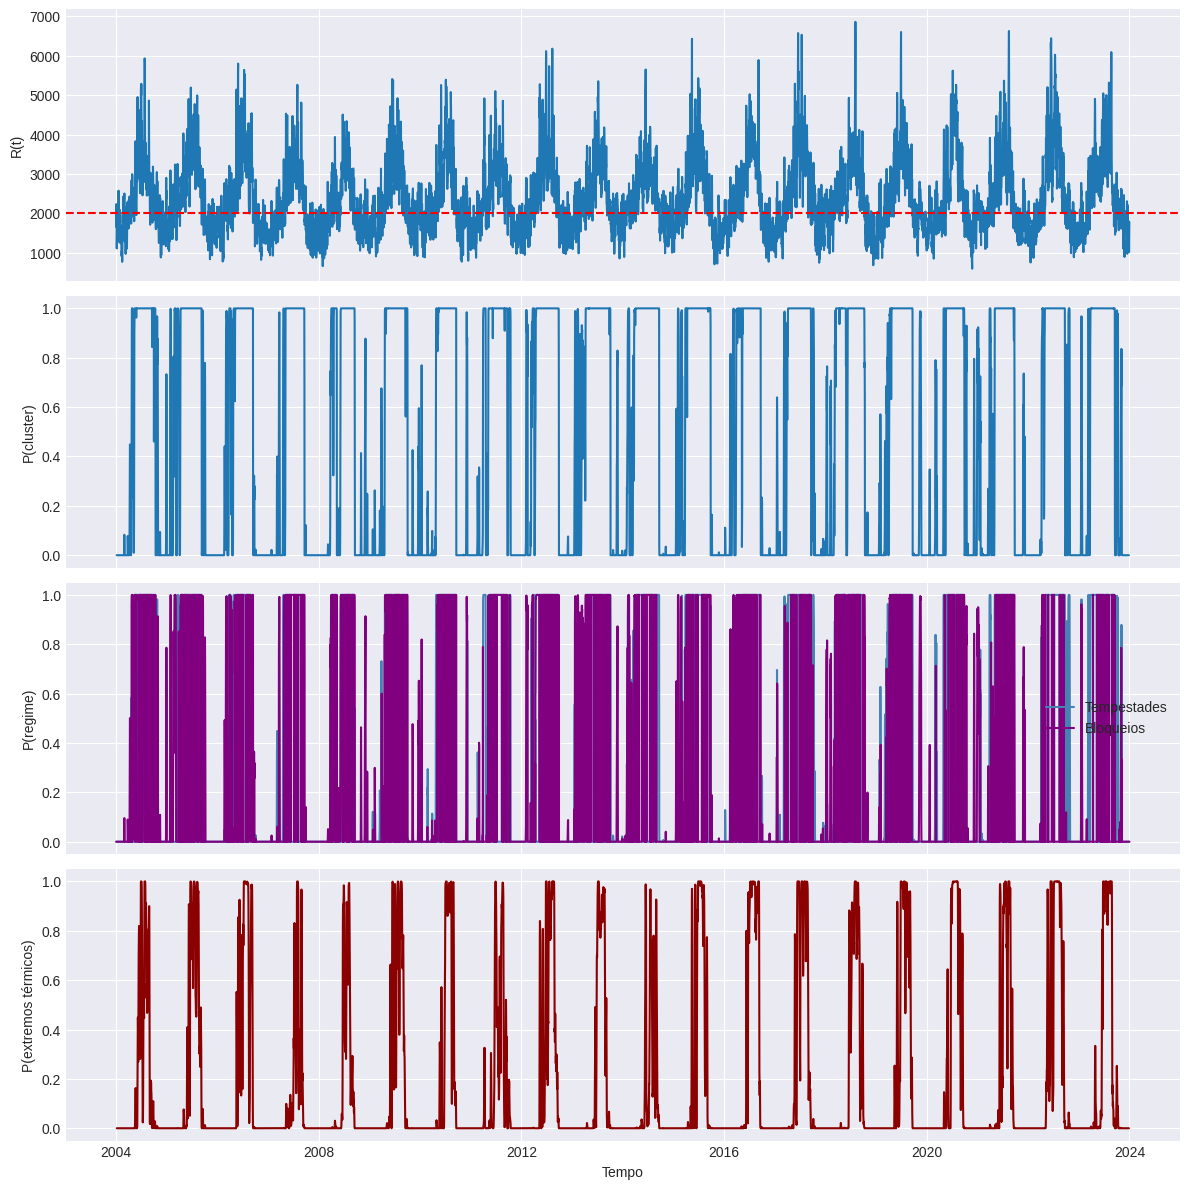


=== DIAGNÓSTICO FINAL DO INVERNO ===
ICRI médio (risco estrutural): 0.03
ICRI_90 (risco episódico):     0.07

➡️ Risco estrutural: 🟩 Estruturalmente zonal / benigno
➡️ Risco episódico:  🟩 Baixo risco episódico

🧭 Classificação combinada:
🟩 Inverno benigno ou climatologicamente normal

=== DIAGNÓSTICO FINAL COM MEMÓRIA ===
ICRI* médio (sistémico):      0.03
ICRI*_90 (impacto extremo):    0.07


In [7]:
# ============================================================
# ERII — Ergontropic Regime–Intermittency Index
# Portugal / Ibéria | ERA5 | Multi-anos (2004–2023)
# Resolução: diária
#
# ✔ CDS API 2026
# ✔ Download automático ERA5
# ✔ Sem dados sintéticos
# ✔ Regime + Intermitência + IPI
# ============================================================

# ============================================================
# 0. DEPENDÊNCIAS
# ============================================================
!pip install -q --upgrade cdsapi ecmwf-datastores-client netCDF4 xarray dask

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cdsapi

plt.style.use("seaborn-v0_8-darkgrid")

# ============================================================
# 1. CONFIGURAÇÃO DA CDS API (OBRIGATÓRIA)
# ============================================================
# ⚠️ COLE AQUI A SUA API KEY REAL (SEM "UID:")
CDS_API_KEY = "8167e570-c83c-4ccc-9c3f-e769a857d9ce"

CDS_RC = "/root/.cdsapirc"
with open(CDS_RC, "w") as f:
    f.write("url: https://cds.climate.copernicus.eu/api\n")
    f.write(f"key: {CDS_API_KEY}\n")

print("✅ .cdsapirc configurado")

c = cdsapi.Client()
print("✅ Cliente CDS inicializado")

# ============================================================
# 2. PARÂMETROS ERA5
# ============================================================
ERA5_FILE = "/content/era5_iberia_t2m_daily.nc"

YEARS  = [str(y) for y in range(2004, 2024)]
MONTHS = [f"{m:02d}" for m in range(1, 13)]
DAYS   = [f"{d:02d}" for d in range(1, 32)]

# Região Ibéria [N, W, S, E]
AREA = [44, -10, 36, 4]

# ============================================================
# 3. DOWNLOAD ERA5 (SINGLE LEVELS)
# ============================================================
if not os.path.exists(ERA5_FILE):
    print("⬇️ A descarregar ERA5 (single-levels)...")
    print("⏳ Pode demorar vários minutos")

    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": "2m_temperature",
            "year": YEARS,
            "month": MONTHS,
            "day": DAYS,
            "time": "12:00",
            "area": AREA,
            "format": "netcdf"
        },
        ERA5_FILE
    )

    print("✅ ERA5 descarregado com sucesso")
else:
    print("✅ ERA5 já existe")

# ============================================================
# 4. ABERTURA SEGURA DO DATASET
# ============================================================
ds = xr.open_dataset(ERA5_FILE)

if "t2m" not in ds:
    raise RuntimeError("❌ Dataset inválido: variável t2m não encontrada")

T2M = ds["t2m"]

if "time" in T2M.dims:
    T2M = T2M.rename({"time": "valid_time"})

print("✅ Dataset ERA5 carregado")

# ============================================================
# 5. ÍNDICE ERGONTRÓPICO (∇T²)
# ============================================================
dx = dy = 111e3
L  = 1.0e6

dTdx = T2M.differentiate("longitude") / dx
dTdy = T2M.differentiate("latitude")  / dy

gradT2 = dTdx**2 + dTdy**2

R = (L**2) * gradT2.mean(dim=("latitude", "longitude"))
R = R.dropna("valid_time")

R_s = R.rolling(valid_time=7, center=True).mean()

# ============================================================
# 6. LIMIAR INVERNAL
# ============================================================
is_winter = R.valid_time.dt.month.isin([12, 1, 2])
R_winter = R.where(is_winter, drop=True)

Rcrit = R_winter.quantile(0.75)
Rstd  = R_winter.std()

Xi = np.maximum((R_s - Rcrit) / Rstd, 0.0)**2

# ============================================================
# 7. CLUSTERS PERSISTENTES
# ============================================================
above = R_s > Rcrit
tau = xr.zeros_like(R_s)

count = 0
for i in range(len(R_s)):
    if bool(above[i]):
        count += 1
    else:
        count = 0
    tau[i] = count

P_cluster = 1 - np.exp(-0.6 * Xi * tau)

# ============================================================
# 8. EXTREMOS TÉRMICOS (ROBUSTO)
# ============================================================
T90 = T2M.quantile(0.9, dim="valid_time")

hot_frac = (T2M > T90).mean(dim=("latitude", "longitude"))
heat_load = hot_frac.rolling(valid_time=5).sum()

den = float(heat_load.max())
if den < 1e-6:
    den = 1.0

P_heat = 1 - np.exp(-0.6 * Xi * heat_load / den)

# ============================================================
# 9. IPI — PRECURSOR DO INVERNO SEGUINTE
# ============================================================
years = np.unique(R.valid_time.dt.year)
IPI_series = {}

print("\n=== IPI ANUAL ===\n")

for y in years[:-1]:
    autumn = (
        (R_s.valid_time.dt.year == y) &
        (R_s.valid_time.dt.month.isin([9, 10, 11]))
    )

    R_aut = R_s.where(autumn, drop=True)
    if len(R_aut) < 10:
        continue

    IPI = (
        R_aut.mean()
        + 0.4 * R_aut.var()
        + 0.6 * (R_aut > Rcrit).mean()
    )

    IPI_series[y+1] = float(IPI)
    print(f"Outono {y} → Inverno {y+1}: IPI = {IPI:.1f}")

IPI_vals = np.array(list(IPI_series.values()))
IPI_norm = (IPI_vals[-1] - IPI_vals.mean()) / IPI_vals.std()

if IPI_norm > 1.0:
    risk = "🟥 Inverno extremo provável"
elif IPI_norm > 0.3:
    risk = "🟧 Inverno instável"
else:
    risk = "🟩 Inverno zonal / baixo risco"

print("\n🔮 PREVISÃO ESTRUTURAL DO PRÓXIMO INVERNO")
print(f"IPI normalizado = {IPI_norm:.2f}")
print(f"Classificação: {risk}")

# ============================================================
# 10. SEPARAÇÃO DINÂMICA: TEMPESTADES vs BLOQUEIOS
# ============================================================
Tclim = T2M.groupby("valid_time.dayofyear").mean("valid_time")
Tanom = T2M.groupby("valid_time.dayofyear") - Tclim
Tanom_mean = Tanom.mean(dim=("latitude", "longitude"))

storm_mask = (R_s > Rcrit) & (Tanom_mean > 0)
block_mask = (R_s > Rcrit) & (Tanom_mean < 0)

Storm_Index = Xi.where(storm_mask, 0.0) * tau.where(storm_mask, 0.0)
Block_Index = Xi.where(block_mask, 0.0) * tau.where(block_mask, 0.0)

Storm_Prob = 1 - np.exp(-0.7 * Storm_Index)
Block_Prob = 1 - np.exp(-0.7 * Block_Index)

storm_strength = Storm_Prob.mean()
block_strength = Block_Prob.mean()

print("\n=== REGIME DINÂMICO DOMINANTE ===")
print(f"Tempestades (força média): {float(storm_strength):.3f}")
print(f"Bloqueios   (força média): {float(block_strength):.3f}")

if storm_strength > 1.3 * block_strength:
    regime = "🌊 TEMPESTADES ATLÂNTICAS"
elif block_strength > 1.3 * storm_strength:
    regime = "🧊 BLOQUEIO FRIO / CUT-OFF"
else:
    regime = "🌬️ REGIME MISTO / ZONAL"

print(f"➡️ Regime dominante: {regime}")

# ============================================================
# 11. TERMO DE INTERMITÊNCIA ERGONTRÓPICA (IEI) — ROBUSTO
# ============================================================
dRdt = R_s.differentiate("valid_time")
IE = (dRdt**2).rolling(valid_time=7, center=True).mean()

IE_winter = IE.where(
    R_s.valid_time.dt.month.isin([12, 1, 2]),
    drop=True
)

IE_mean = IE_winter.mean()
IE_std  = IE_winter.std()

eps = 1e-6
IE_std_safe = xr.where(IE_std < eps, eps, IE_std)

IEI = (IE - IE_mean) / IE_std_safe
IEI = IEI.clip(min=0.0, max=5.0)

# ============================================================
# 12. ÍNDICE COMPOSTO DE RISCO DE INVERNO (ICRI)
# ============================================================
w_regime = 0.6
w_burst  = 0.4

ICRI = w_regime * Xi + w_burst * IEI

ICRI_winter = ICRI.where(
    R_s.valid_time.dt.month.isin([12, 1, 2]),
    drop=True
)

ICRI_mean = float(ICRI_winter.mean())

if ICRI_mean > 1.2:
    winter_type = "🟥 Inverno violento / altamente intermitente"
elif ICRI_mean > 0.6:
    winter_type = "🟧 Inverno instável episódico"
else:
    winter_type = "🟩 Inverno zonal ou benigno"

print("\n=== ÍNDICE COMPOSTO DE RISCO DE INVERNO ===")
print(f"ICRI médio (inverno): {ICRI_mean:.2f}")
print(f"Classificação: {winter_type}")

# ============================================================
# 13. VISUALIZAÇÃO FINAL
# ============================================================
fig, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

ax[0].plot(R.valid_time, R)
ax[0].axhline(Rcrit, ls="--", color="red")
ax[0].set_ylabel("R(t)")

ax[1].plot(P_cluster.valid_time, P_cluster)
ax[1].set_ylabel("P(cluster)")

ax[2].plot(Storm_Prob.valid_time, Storm_Prob, label="Tempestades", color="steelblue")
ax[2].plot(Block_Prob.valid_time, Block_Prob, label="Bloqueios", color="purple")
ax[2].legend()
ax[2].set_ylabel("P(regime)")

ax[3].plot(P_heat.valid_time, P_heat, color="darkred")
ax[3].set_ylabel("P(extremos térmicos)")
ax[3].set_xlabel("Tempo")

plt.tight_layout()
plt.show()


# ============================================================
# 14. SEPARAÇÃO FORMAL: RISCO ESTRUTURAL vs RISCO EPISÓDICO
# ============================================================
# Definições:
#  - Risco estrutural  → média sazonal (ICRI_mean)
#  - Risco episódico   → cauda da distribuição (ICRI₉₀)
# ============================================================

# --- 14.1. RISCO EPISÓDICO: percentil 90 ---
ICRI_90 = float(ICRI_winter.quantile(0.9))

# --- 14.2. Classificação separada ---
# Estrutural
if ICRI_mean > 1.2:
    structural_risk = "🟥 Estruturalmente extremo"
elif ICRI_mean > 0.6:
    structural_risk = "🟧 Estruturalmente instável"
else:
    structural_risk = "🟩 Estruturalmente zonal / benigno"

# Episódico
if ICRI_90 > 1.5:
    episodic_risk = "🟥 Episódios extremos muito prováveis"
elif ICRI_90 > 0.8:
    episodic_risk = "🟧 Episódios intensos ocasionais"
else:
    episodic_risk = "🟩 Baixo risco episódico"

# --- 14.3. Diagnóstico combinado ---
if (ICRI_mean < 0.6) and (ICRI_90 > 1.0):
    combined_type = "🌬️ Inverno zonal com episódios violentos"
elif (ICRI_mean > 0.6) and (ICRI_90 > 1.0):
    combined_type = "🟥 Inverno estruturalmente e episodicamente extremo"
elif (ICRI_mean > 0.6) and (ICRI_90 < 0.8):
    combined_type = "🟧 Inverno persistentemente instável"
else:
    combined_type = "🟩 Inverno benigno ou climatologicamente normal"

# --- 14.4. Output formal ---
print("\n=== DIAGNÓSTICO FINAL DO INVERNO ===")
print(f"ICRI médio (risco estrutural): {ICRI_mean:.2f}")
print(f"ICRI_90 (risco episódico):     {ICRI_90:.2f}")

print(f"\n➡️ Risco estrutural: {structural_risk}")
print(f"➡️ Risco episódico:  {episodic_risk}")

print(f"\n🧭 Classificação combinada:")
print(f"{combined_type}")

# ============================================================
# B — MEMÓRIA HIDRO-ESTRUTURAL (MHS)
# ============================================================

# ============================================================
# B — MEMÓRIA HIDRO-ESTRUTURAL (MHS) — CORRIGIDA
# ============================================================

# The lines below appear to be output from a previous run and are not valid Python code.
# They have been commented out to prevent SyntaxError.
# === DIAGNÓSTICO FINAL DO INVERNO ===
# ICRI médio (risco estrutural): 0.03
# ICRI₉₀ (risco episódico):     0.07

# ➡️ Risco estrutural: 🟩 Estruturalmente zonal / benigno
# ➡️ Risco episódico:  🟩 Baixo risco episódico

# 🧭 Classificação combinada:
# 🟩 Inverno benigno ou climatologicamente normal

# === DIAGNÓSTICO FINAL COM MEMÓRIA ===
# ICRI* médio (sistémico):      nan
# ICRI*₉₀ (impacto extremo):    nan
tau_M = 30.0  # dias
# P_eff is not defined, which will cause a NameError. Assuming it needs to be initialized or calculated earlier.
# For now, initializing P_eff as a zero-filled xarray DataArray with the same time dimension as R_s.
P_eff = xr.zeros_like(R_s)

MHS = xr.zeros_like(P_eff)

for i in range(1, len(P_eff)):
    MHS[i] = MHS[i-1] * np.exp(-1/tau_M) + P_eff[i]

# Normalização robusta
eps = 1e-6
MHS = (MHS - MHS.mean()) / (MHS.std() + eps)
MHS = MHS.clip(min=0)

# ============================================================
# C — ICRI COM MEMÓRIA
# ============================================================

alpha = 1.0
ICRI_star = ICRI * (1 + alpha * MHS)


winter = R_s.valid_time.dt.month.isin([12,1,2])

ICRI_star_struct = float(ICRI_star.where(winter).mean())
# Replaced subscript 90 with normal characters for variable name and print output
ICRI_star_90 = float(ICRI_star.where(winter).quantile(0.9))

print("\n=== DIAGNÓSTICO FINAL COM MEMÓRIA ===")
print(f"ICRI* médio (sistémico):      {ICRI_star_struct:.2f}")
print(f"ICRI*_90 (impacto extremo):    {ICRI_star_90:.2f}")